In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
archivo_entrada = 'D:\\DDAA\\Sprint10\\metriques_martstips_categories.xlsx'
df = pd.read_excel(archivo_entrada)
df.shape[0]

657

# Descripció del contingut de marts.tips

## Visulització de les categories i subcategories

In [3]:
df['Category'].value_counts()

Category
Llar             250
Festivitats      160
Oci i Cultura     93
Cura personal     73
Altres            49
Gadgets           32
Name: count, dtype: int64

Veiem que el número de Festivitats és molt elevat. Això és perquè hi ha moltes publicacions (concretament, 124) corresponents al calendari d'advent. Això no ho hem de perdre de vista quan mirem els resultats. 

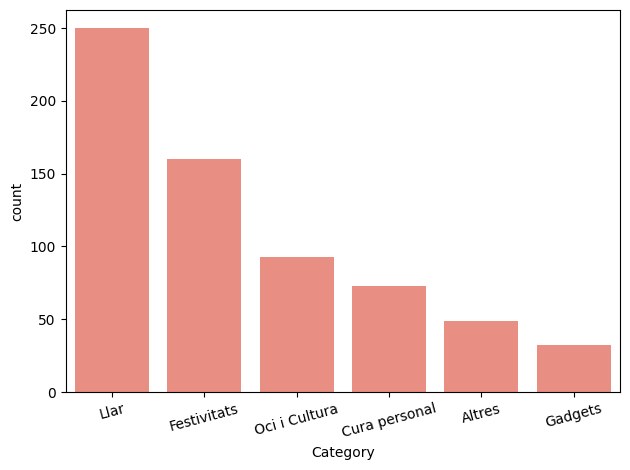

In [4]:
sns.countplot(df, x='Category',
              order=df['Category'].value_counts().index,
              color='salmon')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

Mirem quants posts hi ha per subcategoria. Ho farem amb Flourish. Creem el df.

In [6]:
df_subcategories = df.groupby(['Category', 'Subcategory']).size().reset_index(name='count')
df_subcategories.to_csv('df_subcategories.csv', index=False)

## Anàlisi de la freqüència de publicació.

In [7]:
# Ens assegurem que 'Publication Date' és de tipus datetime
df['Publication Date'] = pd.to_datetime(df['Publication Date'], dayfirst=True)

# Creem una nova columna amb any i mes en format 'YYYY-MM'
df['YearMonth'] = df['Publication Date'].dt.to_period('M').astype(str)
# Creem una altra amb any
df['Year'] = df['Publication Date'].dt.to_period('Y').astype(str)
# I una altra amb mes (en català)
mesos_cat = {
    'January': 'Gener', 'February': 'Febrer', 'March': 'Març',
    'April': 'Abril', 'May': 'Maig', 'June': 'Juny',
    'July': 'Juliol', 'August': 'Agost', 'September': 'Setembre',
    'October': 'Octubre', 'November': 'Novembre', 'December': 'Desembre'
}

df['Mes'] = df['Publication Date'].dt.month_name().map(mesos_cat)

# Aprofitem per crear una nova columna amb el dia de la setmana que es va publicar el vídeo
df['Weekday'] = df['Publication Date'].dt.day_name()

# Ho traduïm al català
dies_cat = {
    'Monday': 'Dilluns',
    'Tuesday': 'Dimarts',
    'Wednesday': 'Dimecres',
    'Thursday': 'Dijous',
    'Friday': 'Divendres',
    'Saturday': 'Dissabte',
    'Sunday': 'Diumenge'
}

df['Weekday'] = df['Weekday'].map(dies_cat)

In [8]:
df_frequencia_publicacio = (
    df
    .groupby(['YearMonth'])
    .size()
    .reset_index(name='Número Posts')
)

df_frequencia_publicacio.to_csv('frequencia_publicacio.csv', index=False)

In [9]:
# Defineix l'ordre dels mesos en català
ordre_mesos = ['Gener', 'Febrer', 'Març', 'Abril', 'Maig', 'Juny',
               'Juliol', 'Agost', 'Setembre', 'Octubre', 'Novembre', 'Desembre']

# Converteix la columna 'Mes' en categoria ordenada
df['Mes'] = pd.Categorical(df['Mes'], categories=ordre_mesos, ordered=True)

# Agrupar i comptar
df_frequencia_publicacio_anual = (
    df
    .groupby(['Year','Mes'])
    .size()
    .reset_index(name='Número Posts')
)

# Ordenar els mesos abans del pivot
df_frequencia_publicacio_anual = df_frequencia_publicacio_anual.sort_values(by='Mes')

# Reformular taula amb Mesos com a files i Anys com a columnes
df_frequencia_publicacio_anual_wide = (
    df_frequencia_publicacio_anual
    .pivot(index='Mes', columns='Year', values='Número Posts')
    .fillna(0)
    .astype(int)
    .reset_index()
)

# Exportar a CSV
df_frequencia_publicacio_anual_wide.to_csv('frequencia_publicacio_anual.csv', index=False)


C:\Users\gemma\AppData\Local\Temp\ipykernel_33320\3096955829.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['Year','Mes'])


## Freqüència publicació per categoria

Ara volem veure l'evolució de la quantitat de vídeos publicats de cada categoria al llarg del temps amb una granularitat de mes.

In [10]:
df_evolution = (
    df
    .groupby(['YearMonth', 'Category'])
    .size()
    .reset_index(name='Número Posts')
)

# Reformular per tenir les dates com a columnes
df_wide = df_evolution.pivot(index='YearMonth', columns='Category', values='Número Posts').fillna(0).astype(int).reset_index()

df_wide.to_csv('category_time_series.csv', index=False)

# Anàlisi del contingut amb més èxit

En base a què definim l'èxit? Tenim visualitzacions, likes, comments, shares, saved... En què ens basem per dir si un vídeo té èxit o no?

Mirem la correlació de tots aquests paràmetres. 

In [11]:
# Mirem si la distribució de les variables és normal per saber si hem de fer pearson o spearman
from scipy.stats import shapiro
stat, p = shapiro(df['Views'])  
print(stat,p)  # p = .001 --> Reject the null hypothesis. Therefore, the distribution is not normal
stat, p = shapiro(df['Likes']) 
print(stat,p) 
stat, p = shapiro(df['Saves']) 
print(stat,p)  
stat, p = shapiro(df['Shares']) 
print(stat,p) 
stat, p = shapiro(df['Comments']) 
print(stat,p)  

# p < .05 --> Reject the null hypothesis. Therefore, the distribution is not normal

nan nan
0.20823758242104295 5.412659119449935e-46
0.24202519964016822 2.4435181330294826e-45
0.24068316971188497 2.2990998010784883e-45
0.18927590327743882 2.377610190058536e-46


In [12]:
numeric_df = df[['Views','Likes','Saves','Shares','Comments']]

In [13]:
from scipy.stats import spearmanr
# Calcular matriu de correlació i p-valors
corr_matrix, pval_matrix = spearmanr(numeric_df, nan_policy='omit')

# Convertir en DataFrames
cols = numeric_df.columns
corr_df = pd.DataFrame(corr_matrix, index=cols, columns=cols)
pval_df = pd.DataFrame(pval_matrix, index=cols, columns=cols)

In [14]:
corr_df

,Views,Likes,Saves,Shares,Comments
Views,1.000000,0.928489,0.877456,0.811316,0.812520
Likes,0.928489,1.000000,0.883333,0.775793,0.854162
Saves,0.877456,0.883333,1.000000,0.914874,0.766450
Shares,0.811316,0.775793,0.914874,1.000000,0.702217
Comments,0.812520,0.854162,0.766450,0.702217,1.000000


In [15]:
pval_df

,Views,Likes,Saves,Shares,Comments
Views,0.000000e+00,1.482880e-283,7.584252e-211,1.298994e-154,1.988443e-155
Likes,1.482880e-283,0.000000e+00,1.026229e-217,4.138842e-133,3.534439e-188
Saves,7.584252e-211,1.026229e-217,0.000000e+00,3.380281e-260,4.771828e-128
Shares,1.298994e-154,4.138842e-133,3.380281e-260,0.000000e+00,1.014258e-98
Comments,1.988443e-155,3.534439e-188,4.771828e-128,1.014258e-98,0.000000e+00


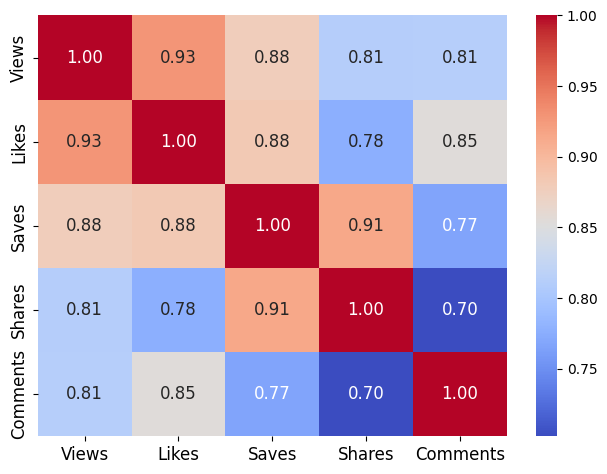

In [16]:
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f",  annot_kws={"size": 12})
plt.title('')
plt.tight_layout()

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('correlation_matrix.jpeg', format='jpeg', dpi=300, bbox_inches='tight')
plt.show()

Totes les variables estan altament correlacionades. Per tant, utilitzarem les visualitzacions com a indicador d'èxit. Analitzarem aquells vídeos que s'han fet virals.

Com definim el llindar? A partir de quantes visualitzacions diem que s'ha fet viral? Agafarem el 10% de vídeos amb més visualitzacions.

In [17]:
# Eliminem una observació que té nan Views
df = df[df['Views'].notna()]
np.percentile(df['Views'], np.arange(0, 100, 10))

array([  1469.,   9950.,  16700.,  25700.,  36700.,  48100.,  71200.,
       108050., 167600., 545150.])

In [18]:
df_viral = df[df['Views'] >= 545150]
df_viral.shape[0]

66

Això ens deixa amb 66 vídeos. 

I ara ens preguntem:

- A quines categories pertanyen els vídeos més vistos? Quines categories tenen de mitjana un major número de visualitzacions?

- Quins son els hashtags més exitosos? 

- Els vídeos de publicitat tenen més visualitzacions?

- Quin dia de la setmana és millor per publicar? Això és perillós perquè no vol dir que el vídeo es viralitzés el mateix dia que es va publicar.

- Quan s'han publicat aquests vídeos? Hi ha alguna època de l'any que sigui més propensa a les viralitzacions? És una mica perillós pel mateix que comentàvem abans. 

In [19]:
# Abans de res deixa'm mirar si dins els virals hi ha algun que es dispari moltíssim.

def iqr_outliers(series):
    Q1 = np.percentile(series, 25)
    Q3 = np.percentile(series, 75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
    print(f"Lower bound: {lower}, Upper bound: {upper}")
    print(f"Values below lower: {(series < lower).sum()}")
    print(f"Values above upper: {(series > upper).sum()}")

    return series[(series < lower) | (series > upper)].index

In [20]:
df_viral.loc[iqr_outliers(df_viral['Views'])]

Q1: 791625.0, Q3: 3200000.0, IQR: 2408375.0
Lower bound: -2820937.5, Upper bound: 6812562.5
Values below lower: 0
Values above upper: 5


,Video Links,Views,Likes,Comments,Shares,Saves,Hashtags,Publication Date,Audio Label,FilteredHashtags,Category,Subcategory,Publicitat,YearMonth,Year,Mes,Weekday
102,https://www.tiktok.com/@martstips/video/695628...,8600000.0,1300000,2205,12600,91000,"['rosa', 'rosal', 'santjordi', 'plantar', 'apr...",2021-04-28,Roses - Adam Lambert & Nile Rodgers,"['rosa', 'rosal', 'santjordi', 'plantar', 'apr...",Llar,Trucs pel dia a dia,0,2021-04,2021,Abril,Dimecres
189,https://www.tiktok.com/@martstips/video/700488...,7500000.0,254300,1127,3996,11400,"['trucosytips', 'aprendecontiktok', 'amazonfin...",2021-09-06,Quirky - Oleg Kirilkov,"['aprendecontiktok', 'amazonfinds', 'cerradura...",Gadgets,Amazon,1,2021-09,2021,Setembre,Dilluns
208,https://www.tiktok.com/@martstips/video/701489...,7100000.0,299800,781,34900,43000,"['trucosytips', 'orden', 'tips', 'tipsorden', ...",2021-10-03,sonido original - Marts Tips,"['orden', 'tipsorden', 'lifehack', 'aprendecon...",Llar,Ordre i Decoració,0,2021-10,2021,Octubre,Diumenge
210,https://www.tiktok.com/@martstips/video/701602...,10500000.0,1600000,3947,30200,91200,"['trucosytips', 'orden', 'tips', 'tipsorden', ...",2021-10-06,Pieces (Solo Piano Version) - Danilo Stankovic,"['orden', 'tipsorden', 'aprendecontiktok', 'ru...",Llar,Ordre i Decoració,0,2021-10,2021,Octubre,Dimecres
346,https://www.tiktok.com/@martstips/video/718077...,9300000.0,766300,437,4248,55700,"['escaperoom', 'calendariodeadviento', 'escape...",2022-12-24,Epic Music(863502) - Draganov89,"['escaperoom', 'calendariodeadviento', 'escape...",Festivitats,Calendari Advent,0,2022-12,2022,Desembre,Dissabte


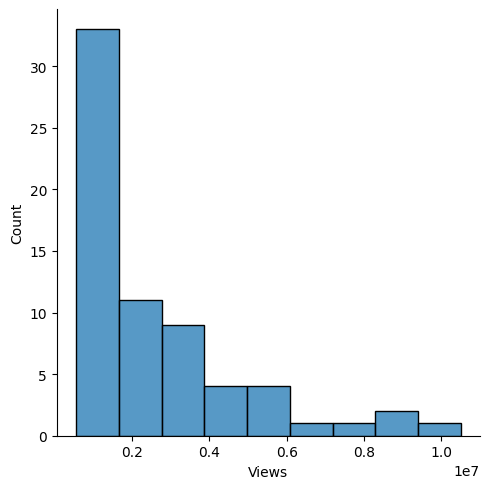

In [21]:
sns.displot(df_viral['Views'])

## A quines categories pertanyen els vídeos més vistos?

In [22]:
df_viral_subcategories = df_viral.groupby(['Category', 'Subcategory']).size().reset_index(name='count')
df_viral_subcategories.to_csv('df_viral_subcategories.csv', index=False)


## Quines són les categories amb una mediana de visualitzacions més alta?

In [35]:
df_viral_views_per_subcat = (
    df_viral.groupby('Subcategory')
    .agg(Mediana_de_Visualitzacions=('Views', 'median'),
         Nombre_de_Videos=('Views', 'count'))
    .reset_index()
)
top5_subcategories = df_viral_views_per_subcat.sort_values(by='Mediana_de_Visualitzacions', ascending=False).head(5)
top5_subcategories
top5_subcategories.to_csv('top5_subcategories_median.csv', index=False)


## Quins són els hashtags més exitosos?

In [ ]:
# Eliminem els claudàtors
df_viral['Hashtags'] = df_viral['Hashtags'].astype(str).str.strip("[]")

# Netegem cada hashtag
def clean_hashtag_list(x):
    if isinstance(x, list):
        return [tag.strip().lower().replace('#', '') for tag in x if isinstance(tag, str) and tag.strip()]
    elif isinstance(x, str):
        return [
            tag.strip().lower().replace('#', '').strip("'").strip('"')  # Remove #, whitespace, and quotes
            for tag in x.split(',')
            if tag.strip()
        ]
    else:
        return []

df_viral['Hashtags'] = df_viral['Hashtags'].apply(clean_hashtag_list)


# Separem els diferents hashtag d'un mateix vídeo en diferents files
df_exploded = df_viral.explode('Hashtags')

# Agrupem per hashtag i sumem les visualitzacions
hashtag_views = df_exploded.groupby('Hashtags')['Views'].sum().reset_index()
hashtag_views.columns = ['Word', 'Size']
hashtag_views = hashtag_views.sort_values(by='Size', ascending=False)


hashtag_views.to_csv("top_hashtag_views_wordcloud.csv", index=False)
hashtag_views

C:\Users\gemma\AppData\Local\Temp\ipykernel_33320\696133907.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_viral['Hashtags'] = df_viral['Hashtags'].astype(str).str.strip("[]")
C:\Users\gemma\AppData\Local\Temp\ipykernel_33320\696133907.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_viral['Hashtags'] = df_viral['Hashtags'].apply(clean_hashtag_list)


,Word,Size
128,trucosytips,108002300.0
7,aprendecontiktok,88736300.0
110,tips,57511100.0
71,orden,38932700.0
119,tipsorden,35732700.0
...,...,...
76,pececillodeplata,624400.0
127,trampas,624400.0
124,tipsropa,614800.0
58,llaverosdefensapersonal,604700.0


## Els vídeos de publicitat tenen més probabilitats de fer-se virals?

In [25]:
df_no_viral = df[df['Views'] < 545150]
df_no_viral.shape[0]

590

In [26]:
from scipy.stats import chi2_contingency

# Get value counts for both dataframes
viral_counts = df_viral['Publicitat'].value_counts()
no_viral_counts = df_no_viral['Publicitat'].value_counts()

# Create contingency table
contingency_table = pd.DataFrame({
    'Publicitat': [viral_counts[1], no_viral_counts[1]],
    'No publicitat': [viral_counts[0], no_viral_counts[0]]
}, index=['Viral', 'No Viral'])

# Perform chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Show results
print("Contingency Table:")
print(contingency_table)
print("\nChi-squared Test:")
print(f"Chi2 statistic: {chi2:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p:.4f}")


Contingency Table:
          Publicitat  No publicitat
Viral             16             50
No Viral         169            421

Chi-squared Test:
Chi2 statistic: 0.3714
Degrees of freedom: 1
P-value: 0.5422


No hi ha diferències significatives entre les dues mostres. Okay, els de publicitat no tenen més probabilitat de viralitzar-se. No obstant, això ho estem mirant havent fet una classificació "artifical" en viral i no viral en funció de les visualitzacions. I si mirem directament el df original amb tots els vídeos i l'efecte de la publicitat en el nombre de visualitzacions?

In [27]:
## Efecte de la publicitat en el nombre de visualitzacions

In [28]:
from scipy.stats import ttest_ind

# Split into the 2 subgroups

p1 = df[df['Publicitat']==1]['Views']
p0 = df[df['Publicitat']==0]['Views']

# Perform independent t-tests within each virality group
t_test_publi = ttest_ind(p1, p0, equal_var=False)

print("Publicitat 1 vs 0:")
print(t_test_publi)

Publicitat 1 vs 0:
TtestResult(statistic=np.float64(-1.1419451403787857), pvalue=np.float64(0.2541063175471959), df=np.float64(434.0979934644994))


## Quin dia de la setmana és millor per publicar? 

Això és perillós perquè no vol dir que el vídeo es viralitzés el mateix dia que es va publicar.

Tenint això en ment, calculem la mitjana de visualitzacions per vídeo segons el dia de publicació

In [29]:
avg_views_per_day = df.groupby('Weekday')['Views'].mean().reindex([
    'Dilluns', 'Dimarts', 'Dimecres', 'Dijous', 'Divendres', 'Dissabte', 'Diumenge'
])

avg_views_per_day.to_csv('Mitjana_visualitzacions_weekday.csv', index=True)
avg_views_per_day

Weekday
Dilluns      209650.912000
Dimarts      290453.336364
Dimecres     398006.552632
Dijous       297925.184211
Divendres    279011.476923
Dissabte     393425.596774
Diumenge     467393.984848
Name: Views, dtype: float64

## Quan s'han publicat aquests vídeos? Hi ha alguna època de l'any que sigui més propensa a les viralitzacions? 

És una mica perillós pel mateix que comentàvem abans i perquè el volum de publicacions no ha estat constant al llarg d'aquests cinc anys...

In [30]:
# Converteix la columna 'Mes' en categoria ordenada
#df['Mes'] = pd.Categorical(df['Mes'], categories=ordre_mesos, ordered=True)

# Agrupar i comptar
avg_views_per_month_year = (
    df_viral
    .groupby(['Year','Mes'])['Views']
    .mean()
    .reset_index(name='Número Visualitzacions')
)

# Ordenar els mesos abans del pivot
avg_views_per_month_year = avg_views_per_month_year.sort_values(by='Mes')

# Reformular taula amb Mesos com a files i Anys com a columnes
avg_views_per_month_year_wide = (
    avg_views_per_month_year
    .pivot(index='Mes', columns='Year', values='Número Visualitzacions')
    .fillna(0)
    .astype(int)
    .reset_index()
)

# Exportar a CSV
avg_views_per_month_year_wide.to_csv('Mitjana_visualitzacions_mes_any.csv', index=False)
avg_views_per_month_year_wide

C:\Users\gemma\AppData\Local\Temp\ipykernel_33320\1736463112.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['Year','Mes'])['Views']


Year,Mes,2020,2021,2022,2023,2024,2025
0,Gener,0,730150,2850000,702700,828600,0
1,Febrer,0,706500,957400,0,5700000,0
2,Març,0,2496333,1289400,2660000,0,2861050
3,Abril,0,3825000,2564533,0,0,1400000
4,Maig,0,1300000,932700,0,572000,4800000
5,Juny,0,1800000,0,1656366,1100000,0
6,Juliol,0,1600000,0,0,0,0
7,Agost,0,3200000,0,0,0,0
8,Setembre,0,4350000,0,0,0,0
9,Octubre,0,3466650,0,847700,624400,0


In [31]:
# Els 0 estan bé? No hi havia cap vídeo 'viral', aquell mes? Comprovem-ho

pd.set_option('display.max_rows', 70)
df_viral.sort_values(by='Publication Date')

,Video Links,Views,Likes,Comments,Shares,Saves,Hashtags,Publication Date,Audio Label,FilteredHashtags,Category,Subcategory,Publicitat,YearMonth,Year,Mes,Weekday
20,https://www.tiktok.com/@martstips/video/690985...,2500000.0,429200,1060,5026,32500,"[regalos, envolverregalos, navidad, xmas, chri...",2020-12-24,Santa Claus Is Coming to Town - Michael Bublé,"['regalos', 'envolverregalos', 'navidad', 'xma...",Festivitats,Nadal,0,2020-12,2020,Desembre,Dijous
27,https://www.tiktok.com/@martstips/video/691324...,695600.0,72600,458,2650,4588,"[lackto, collar, lactancia, lechematerna]",2021-01-02,Another Love - Tom Odell,"['lackto', 'collar', 'lactancia', 'lechematerna']",Altres,Altres,0,2021-01,2021,Gener,Dissabte
35,https://www.tiktok.com/@martstips/video/691622...,764700.0,74700,464,3059,5260,"[tutorial, vela, candles, candlemaking]",2021-01-10,NaN,"['tutorial', 'vela', 'candles', 'candlemaking']",Oci i Cultura,DIY,0,2021-01,2021,Gener,Diumenge
54,https://www.tiktok.com/@martstips/video/692624...,706500.0,32299,231,498,1309,"[coche, tips, carhacks, tipscoche]",2021-02-06,Fast Car - Boyce Avenue,"['coche', 'carhacks', 'tipscoche']",Llar,Trucs pel dia a dia,0,2021-02,2021,Febrer,Dissabte
69,https://www.tiktok.com/@martstips/video/693811...,956200.0,68600,506,2188,2561,"[cafeconleche, coffeelover, nespresso, lattiss...",2021-03-10,Death Bed (Acoustic Instrumental) - Instrument...,"['cafeconleche', 'coffeelover', 'nespresso', '...",Altres,Altres,1,2021-03,2021,Març,Dimecres
72,https://www.tiktok.com/@martstips/video/693961...,5700000.0,650200,3384,14000,57000,"[primeravez, geocaching, geocachers, geocache,...",2021-03-14,Mission Impossible (Main Theme) - Favorite Mov...,"['primeravez', 'geocaching', 'geocachers', 'ge...",Oci i Cultura,Geocaching,0,2021-03,2021,Març,Diumenge
76,https://www.tiktok.com/@martstips/video/694222...,832800.0,127000,1007,2032,8016,"[geocaching, geocachers, geocache, missionimpo...",2021-03-21,Mission Impossible (Main Theme) - TV Series Music,"['geocaching', 'geocachers', 'geocache', 'miss...",Oci i Cultura,Geocaching,0,2021-03,2021,Març,Diumenge
87,https://www.tiktok.com/@martstips/video/694923...,2800000.0,491500,1158,2792,24200,"[planes, quepuedohacer, gifted, plandeviernes,...",2021-04-09,Thunderstorm White Noise - Rain,"['planes', 'quepuedohacer', 'gifted', 'plandev...",Oci i Cultura,Plans,1,2021-04,2021,Abril,Divendres
91,https://www.tiktok.com/@martstips/video/695148...,1100000.0,211800,486,1066,12300,"[planes, quepuedohacer, gifted, heladocasero]",2021-04-15,Let Me Have It - The Young Ebenezers,"['planes', 'quepuedohacer', 'gifted', 'heladoc...",Oci i Cultura,Plans,1,2021-04,2021,Abril,Dijous
102,https://www.tiktok.com/@martstips/video/695628...,8600000.0,1300000,2205,12600,91000,"[rosa, rosal, santjordi, plantar, aprendeconti...",2021-04-28,Roses - Adam Lambert & Nile Rodgers,"['rosa', 'rosal', 'santjordi', 'plantar', 'apr...",Llar,Trucs pel dia a dia,0,2021-04,2021,Abril,Dimecres
